In [119]:
import os
import tensorflow as tf
os.environ['KERAS_BACKEND'] = 'tensorflow'

import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
        
PATH = 'input'

sample_df = pd.read_csv('input/sample_submission.csv')
test_ids = sample_df.id.values

In [120]:
from sklearn.model_selection import KFold

FOLDS_CSV = os.path.join(PATH, 'folds.csv')
def generate_folds():
    n_fold = 5
    depths = pd.read_csv(os.path.join(PATH, 'depths.csv'))
    depths.sort_values('z', inplace=True)
    depths.drop('z', axis=1, inplace=True)
    depths['fold'] = (list(range(n_fold))*depths.shape[0])[:depths.shape[0]]
    print(depths.head())
    depths.to_csv(FOLDS_CSV, index=False)

if not os.path.exists(FOLDS_CSV):
    generate_folds()


In [121]:
im_width = 128
im_height = 128
im_chan = 1

In [122]:
X_train = np.load('input/X_train2.npy')
y_train = np.load('input/y_train2.npy')
X_test = np.load('input/X_test2.npy')

In [5]:
from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf

    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.

        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved

        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=1, kernel_initializer="he_normal",
                      activation="sigmoid")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [111]:
def load_fold(X_train, y_train, fold):
    train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
    train_ids = train_df.id.values
    
    folds = pd.read_csv(FOLDS_CSV)
    fold_dict = folds.set_index('id').to_dict()['fold']
    
    fold_train = [fold_dict[x]!=fold for x in train_ids]
    fold_val = [fold_dict[x]==fold for x in train_ids]
    
    X_fold, y_fold = X_train[fold_train], y_train[fold_train]    
    X_val, y_val = X_train[fold_val], y_train[fold_val]    
    return X_fold, y_fold, X_val, y_val

def split_patches(X, y):
    X_patches = []
    y_patches = []
    for idx in tqdm(range(X.shape[0])):
        for j in range(0, 128-32+1, 16):
            for i in range(0, 128-32+1, 16):
                x = X[idx, j:j+32, i:i+32]
                X_patches.append(x)
                y_patches.append(np.sum(y[idx, j:j+32, i:i+32]) > 32*32*0.5)
    return np.array(X_patches), np.array(y_patches)
    


In [116]:
from keras.utils import to_categorical

def run_fold(X_fold, y_fold, X_val, y_val, weights_file):
    print(X_fold.shape, y_fold.shape, X_val.shape, y_val.shape)
    model = ResnetBuilder().build_resnet_34((1, 32, 32), 1)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    callbacks = [
        EarlyStopping(patience=5, verbose=1),
        ReduceLROnPlateau(patience=3, verbose=1),
        ModelCheckpoint(weights_file, verbose=1, save_best_only=True)
    ]
        
    data_gen_args = dict(
        #width_shift_range=0.25,
        #height_shift_range=0.25,
        fill_mode='reflect',
        horizontal_flip=True,
        vertical_flip=True,
        #zoom_range=0.1
    )
    image_datagen = ImageDataGenerator(**data_gen_args)
    
    seed = 1
    image_datagen.fit(X_fold, augment=True, seed=seed)

    image_generator = image_datagen.flow(X_fold, y_fold, batch_size=128, seed=seed)    
    
    #results = model.fit(X_fold, y_fold,
    #                    epochs=10,
    #                    validation_split=0.1)

    results = model.fit_generator(
        image_generator, 
        epochs=50, 
        verbose=2,
        steps_per_epoch=len(X_fold)//128,
        callbacks=callbacks,
        validation_data=(X_val, y_val))

    return model

In [117]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


In [ ]:
def stitch_patches(X_patches):
    images = X_patches.shape[0] // 49 # TODO
    out = np.zeros((images, 128, 128), dtype=np.float32)
    patch_idx = 0
    for image_idx in range(out.shape[0]): 
        for j in range(0, 128-32+1, 16):
            for i in range(0, 128-32+1, 16):
                out[image_idx, j:j+32, i:i+32] += X_patches[patch_idx]
                patch_idx += 1
    return out/4.0

def debug_predict(X,):
    x_patches, y_patches = split_patches(X[:, :, :, 0].reshape(-1, 128, 128), y[:, :, :, 0].reshape(-1, 128, 128))
    x_pred = model.predict(x_patches.reshape(-1, 32, 32, 1), verbose=1)
    x_out = stitch_patches(x_pred)
    return x_out

X_test_patches, _ = split_patches(X_test, X_test)

for fold in range(5):
    print('running fold ', fold)    
    X_fold, y_fold, X_val, y_val = load_fold(X_train, y_train, fold)
    
    X_fold_patches, y_fold_patches = split_patches(X_fold, y_fold)
    X_val_patches, y_val_patches = split_patches(X_val, y_val)
    
    weights_file = f"model-patches-fold{fold}.h5"    
    
    model = run_fold(X_fold_patches, y_fold_patches.reshape(-1, 1), X_val_patches, y_val_patches.reshape(-1, 1), weights_file)
    #model = ResnetBuilder().build_resnet_34((1, 32, 32), 1)
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.load_weights(weights_file)
    
    val_preds = model.predict(X_val_patches, verbose=1, batch_size=128)
    np.save(f"val_preds_fold{fold}", val_preds)
    
    test_preds = model.predict(X_test_patches, verbose=1, batch_size=128)
    np.save(f"test_preds_fold{fold}", test_preds)

  0%|          | 0/3190 [00:00<?, ?it/s]

running fold  0


100%|██████████| 810/810 [00:00<00:00, 1252.63it/s]


(156310, 32, 32, 1) (156310, 1) (39690, 32, 32, 1) (39690, 1)
Epoch 1/50
 - 96s - loss: 0.5580 - acc: 0.8767 - val_loss: 0.3411 - val_acc: 0.8967

Epoch 00001: val_loss improved from inf to 0.34112, saving model to model-patches-fold0.h5
Epoch 2/50
 - 83s - loss: 0.3185 - acc: 0.8950 - val_loss: 0.2788 - val_acc: 0.9100

Epoch 00002: val_loss improved from 0.34112 to 0.27879, saving model to model-patches-fold0.h5
Epoch 3/50
 - 83s - loss: 0.2861 - acc: 0.9022 - val_loss: 0.2529 - val_acc: 0.9165

Epoch 00003: val_loss improved from 0.27879 to 0.25292, saving model to model-patches-fold0.h5
Epoch 4/50
 - 83s - loss: 0.2737 - acc: 0.9059 - val_loss: 0.2396 - val_acc: 0.9203

Epoch 00004: val_loss improved from 0.25292 to 0.23956, saving model to model-patches-fold0.h5
Epoch 5/50
 - 83s - loss: 0.2682 - acc: 0.9077 - val_loss: 0.3276 - val_acc: 0.8816

Epoch 00005: val_loss did not improve
Epoch 6/50
 - 83s - loss: 0.2583 - acc: 0.9113 - val_loss: 0.2439 - val_acc: 0.9213

Epoch 00006: v

100%|██████████| 804/804 [00:00<00:00, 1166.96it/s]


(156604, 32, 32, 1) (156604, 1) (39396, 32, 32, 1) (39396, 1)
Epoch 1/50
 - 98s - loss: 0.5568 - acc: 0.8814 - val_loss: 0.3551 - val_acc: 0.8897

Epoch 00001: val_loss improved from inf to 0.35506, saving model to model-patches-fold1.h5
Epoch 2/50
 - 83s - loss: 0.3150 - acc: 0.8965 - val_loss: 0.3015 - val_acc: 0.9006

Epoch 00002: val_loss improved from 0.35506 to 0.30152, saving model to model-patches-fold1.h5
Epoch 3/50
 - 83s - loss: 0.2816 - acc: 0.9048 - val_loss: 0.2754 - val_acc: 0.9054

Epoch 00003: val_loss improved from 0.30152 to 0.27541, saving model to model-patches-fold1.h5
Epoch 4/50
 - 83s - loss: 0.2750 - acc: 0.9062 - val_loss: 0.2948 - val_acc: 0.8991

Epoch 00004: val_loss did not improve
Epoch 5/50
 - 84s - loss: 0.2644 - acc: 0.9103 - val_loss: 0.2634 - val_acc: 0.9138

Epoch 00005: val_loss improved from 0.27541 to 0.26340, saving model to model-patches-fold1.h5
Epoch 6/50
 - 83s - loss: 0.2544 - acc: 0.9132 - val_loss: 0.2848 - val_acc: 0.8965

Epoch 00006: v

100%|██████████| 811/811 [00:00<00:00, 1161.02it/s]


(156261, 32, 32, 1) (156261, 1) (39739, 32, 32, 1) (39739, 1)
Epoch 1/50
 - 100s - loss: 0.5567 - acc: 0.8820 - val_loss: 0.3964 - val_acc: 0.8680

Epoch 00001: val_loss improved from inf to 0.39636, saving model to model-patches-fold2.h5
Epoch 2/50
 - 85s - loss: 0.3148 - acc: 0.8981 - val_loss: 0.3166 - val_acc: 0.8880

Epoch 00002: val_loss improved from 0.39636 to 0.31663, saving model to model-patches-fold2.h5
Epoch 3/50
 - 84s - loss: 0.2794 - acc: 0.9053 - val_loss: 0.3322 - val_acc: 0.8660

Epoch 00003: val_loss did not improve
Epoch 4/50
 - 85s - loss: 0.2713 - acc: 0.9080 - val_loss: 0.3068 - val_acc: 0.8966

Epoch 00004: val_loss improved from 0.31663 to 0.30676, saving model to model-patches-fold2.h5
Epoch 5/50
 - 85s - loss: 0.2621 - acc: 0.9111 - val_loss: 0.2803 - val_acc: 0.9028

Epoch 00005: val_loss improved from 0.30676 to 0.28035, saving model to model-patches-fold2.h5
Epoch 6/50
 - 84s - loss: 0.2531 - acc: 0.9149 - val_loss: 0.2977 - val_acc: 0.8924

Epoch 00006: 

In [100]:
#X_fold, y_fold, X_val, y_val = load_fold(X_train, y_train, fold)
#X_val_patches, y_val_patches = split_patches(X_val, y_val)

def stitch_patches(X_patches):
    images = X_patches.shape[0] // 49 # TODO
    out = np.zeros((images, 128, 128), dtype=np.float32)
    patch_idx = 0
    for image_idx in range(out.shape[0]): 
        for j in range(0, 128-32+1, 16):
            for i in range(0, 128-32+1, 16):
                out[image_idx, j:j+32, i:i+32] += X_patches[patch_idx]
                patch_idx += 1
    return out/4.0

def debug_predict(X,):
    x_patches, y_patches = split_patches(X[:, :, :, 0].reshape(-1, 128, 128), y[:, :, :, 0].reshape(-1, 128, 128))
    x_pred = model.predict(x_patches.reshape(-1, 32, 32, 1), verbose=1)
    x_out = stitch_patches(x_pred)
    return x_out

#x_pred = debug_predict(X_val)


100%|██████████| 810/810 [00:00<00:00, 1117.28it/s]


39690/39690 [==============================] - 16s 410us/step
[[0.79537904]
 [0.9590244 ]
 [0.97290325]
 ...
 [0.6141258 ]
 [0.43407243]
 [0.0606115 ]]


In [123]:
if False:
    for idx in range(10):
        plt.figure()
        plt.imshow(y_val[idx, :, :, 0])
        plt.figure()
        x_pred[idx, 0, 0] = 1
        plt.imshow(x_pred[idx])

In [ ]:
preds = np.zeros_like(X_test)
for fold in range(5):
    p = np.load('preds_fold%s.npy' % fold)
    preds += p
preds /= 5

In [11]:
preds_ = []
for i in tqdm(range(len(preds_test))):
    preds_.append(resize(np.squeeze(preds[i]), (101, 101), mode='constant', preserve_range=True))

  0%|          | 0/18000 [00:00<?, ?it/s]/opt/miniconda2/envs/avito/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 18000/18000 [00:15<00:00, 1160.20it/s]


In [224]:
def get_fold_idx(fold):
    train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
    train_ids = train_df.id.values
    
    folds = pd.read_csv(FOLDS_CSV)
    fold_dict = folds.set_index('id').to_dict()['fold']
    
    fold_train = [ idx for idx, x in enumerate(train_ids) if fold_dict[x]!=fold]
    fold_val = [ idx for idx, x in enumerate(train_ids) if fold_dict[x]==fold]
    return fold_train, fold_val


train_preds = np.zeros((X_train.shape[0], 128, 128), dtype=np.float32)

for fold in range(5):
    train_idx, val_idx = get_fold_idx(fold)
    oof_preds = stitch_patches(np.load(f"val_preds_fold{fold}.npy"))
    for idx in range(oof_preds.shape[0]):
        #x2 = np.zeros((128, 128), dtype=np.float32)
        #x2[:97, :97] = 
        #oof_preds[idx] = x2
        oof_preds[idx] = np.pad(oof_preds[idx, 16:-16, 16:-16], ((16, 16), (16, 16)), mode='symmetric')
    train_preds[val_idx] = oof_preds

train_preds = train_preds.reshape((X_train.shape[0], 128, 128, 1))
np.save('data/subm007/X_train3_stage1oof.npy', train_preds)

In [226]:
test_preds = np.zeros((X_test.shape[0], 128, 128), dtype=np.float32)

for fold in range(5):    
    oof_preds = stitch_patches(np.load(f"test_preds_fold{fold}.npy"))
    for idx in range(oof_preds.shape[0]):
        oof_preds[idx] = np.pad(oof_preds[idx, 16:-16, 16:-16], ((16, 16), (16, 16)), mode='symmetric')
    test_preds += oof_preds
test_preds /= 5.    

test_preds = test_preds.reshape((-1, 128, 128, 1))
np.save('data/subm007/X_test3_stage1oof.npy', test_preds)


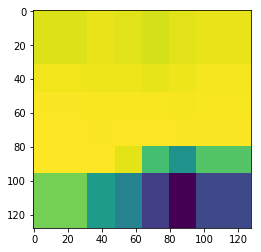

In [228]:
plt.imshow(test_preds[0, :, :, 0])

In [222]:
#workaround matplotlib rescaling
train_preds[:, 50, 50, 0] = 1

for i in range(0):
    plt.figure()
    #plt.imshow(y_train[i, 13:-14, 13:-14, 0])
    plt.imshow(y_train[i, ..., 0])
    plt.figure()
    #plt.imshow(train_preds[i, 13:-14, 13:-14, 0])
    plt.imshow(train_preds[i, ..., 0])
    

In [12]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs



In [13]:

rows = []
for image_id, p in zip(test_ids, preds_):
    rows.append([image_id, RLenc(np.round(p))])
    
sub = pd.DataFrame(rows, columns=['id', 'rle_mask'])
sub.to_csv('submissions/subm_006.csv', index=False)